# Music genre prediction

**Описание задачи**

Вы сотрудник Отдела Data Science популярного музыкального стримингового сервиса. Сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Ваши коллеги из отдела работы со звуком подготовили датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Ваша задача - разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

В ходе работы пройдите все основные этапы полноценного исследования:

*  загрузка и ознакомление с данными
*  предварительная обработка
*  полноценный разведочный анализ
*  разработка новых синтетических признаков
*  проверка на мультиколлинеарность
*  отбор финального набора обучающих признаков
*  выбор и обучение моделей
*  итоговая оценка качества предсказания лучшей модели
*  анализ важности ее признаков

**ВАЖНО**  
Необходимо реализовать решение с использованием технологии `pipeline` (из библиотеки `sklearn`)

**ОЖИДАЕМЫЙ РЕЗУЛЬТАТ**

* Оформленный репозиторий на GitHub (ноутбук с исследованием + код приложения)
* Развернутое web-приложение (с использованием библиотеки Streamlit)

## Участники проекта, репозиторий, приложение

**Участиники:**

Диана Арефьева

Юлия Гущина

Татьяна Круглова

**Репозиторий:**

https://github.com/JuliyaGushchina/Project

## Импорт библиотек, установка констант

In [ ]:
%%capture
!pip install catboost -q

In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, mean_absolute_error

In [ ]:
TRAIN = "https://www.dropbox.com/scl/fi/5zy935lqpaqr9lat76ung/music_genre_train.csv?rlkey=ccovu9ml8pfi9whk1ba26zdda&dl=1"
TEST = "https://www.dropbox.com/scl/fi/o6mvsowpp9r3k2lejuegt/music_genre_test.csv?rlkey=ac14ydue0rzlh880jwj3ebum4&dl=1"

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка и обзор данных

In [ ]:
train = pd.read_csv(TRAIN)
test = pd.read_csv(TEST)

In [ ]:
train.head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
2,87888.0,First Person on Earth,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
3,77021.0,No Te Veo - Digital Single,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
4,20852.0,Chasing Shadows,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative


In [ ]:
# Длина датасета

len(train)

20394

Посмотрим на колличество уникальных значений в разрезе параметров

In [ ]:
unique_count = train['acousticness'].nunique()
unique_count

3616

In [ ]:
unique_count = train['danceability'].nunique()
unique_count

950

In [ ]:
unique_count = train['energy'].nunique()
unique_count

1521

In [ ]:
unique_count = train['instrumentalness'].nunique()
unique_count

4360

In [ ]:
unique_count = train['liveness'].nunique()
unique_count

1521

In [ ]:
unique_count = train['loudness'].nunique()
unique_count

10844

In [ ]:
unique_count = train['speechiness'].nunique()
unique_count

1243

In [ ]:
unique_count = train['tempo'].nunique()
unique_count

15762

In [ ]:
unique_count = train['valence'].nunique()
unique_count

1454

**Описание полей данных**

`instance_id` - уникальный идентификатор трека  
`track_name` - название трека  
`acousticness` - акустичность  
`danceability` - танцевальность  
`duration_ms` -продолжительность в милисекундах  
`energy` - энергичность  
`instrumentalness` - инструментальность  
`key` - тональность  
`liveness` - привлекательность  
`loudness` - громкость  
`mode` - наклонение  
`speechiness` - выразительность  
`tempo` - темп  
`obtained_date` - дата загрузки в сервис  
`valence` - привлекательность произведения для пользователей сервиса  
`music_genre` - музыкальный жанр

## Предварительная обработка данных

### Обзор данных

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

In [ ]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
instance_id,20394.0,55973.846916,20695.792545,20011.00000,38157.25000,56030.000000,73912.750000,91758.000
acousticness,20394.0,0.274783,0.321643,0.00000,0.01520,0.120000,0.470000,0.996
danceability,20394.0,0.561983,0.171898,0.06000,0.45100,0.570000,0.683000,0.978
duration_ms,20394.0,242737.149750,103826.311833,15509.00000,196089.25000,227000.000000,266000.000000,4497994.000
energy,20394.0,0.625276,0.251238,0.00101,0.47000,0.666000,0.830000,0.999
instrumentalness,20394.0,0.159989,0.306503,0.00000,0.00000,0.000144,0.084475,0.996
liveness,20394.0,0.198540,0.166742,0.01360,0.09730,0.130000,0.253000,1.000
loudness,20394.0,-8.552998,5.499917,-44.40600,-10.25575,-7.052000,-5.054000,3.744
speechiness,20394.0,0.091352,0.097735,0.02230,0.03560,0.049050,0.095575,0.942
tempo,19952.0,120.942522,30.427590,34.76500,95.92175,120.012500,141.966250,220.041


In [ ]:
train.describe(include = ['object']).transpose()

,count,unique,top,freq
track_name,20394,18643,Home,11
key,19659,12,G,2304
mode,19888,2,Major,12828
obtained_date,20394,4,4-Apr,18435
music_genre,20394,10,Blues,2858


В данных есть пропущенные значения

In [ ]:
train.isnull().sum()

instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 735
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
obtained_date         0
valence               0
music_genre           0
dtype: int64

Дубликаты отсутсвуют

In [ ]:
train.duplicated().sum()

0

Распределение музыки по жанрам

In [ ]:
train.value_counts('music_genre')

music_genre
Blues          2858
Alternative    2601
Electronic     2564
Rap            2428
Rock           2165
Country        2120
Anime          1901
Classical      1373
Jazz           1239
Hip-Hop        1145
Name: count, dtype: int64

array([[<Axes: title={'center': 'instance_id'}>,
        <Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>],
       [<Axes: title={'center': 'duration_ms'}>,
        <Axes: title={'center': 'energy'}>,
        <Axes: title={'center': 'instrumentalness'}>],
       [<Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'loudness'}>,
        <Axes: title={'center': 'speechiness'}>],
       [<Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'valence'}>, <Axes: >]], dtype=object)

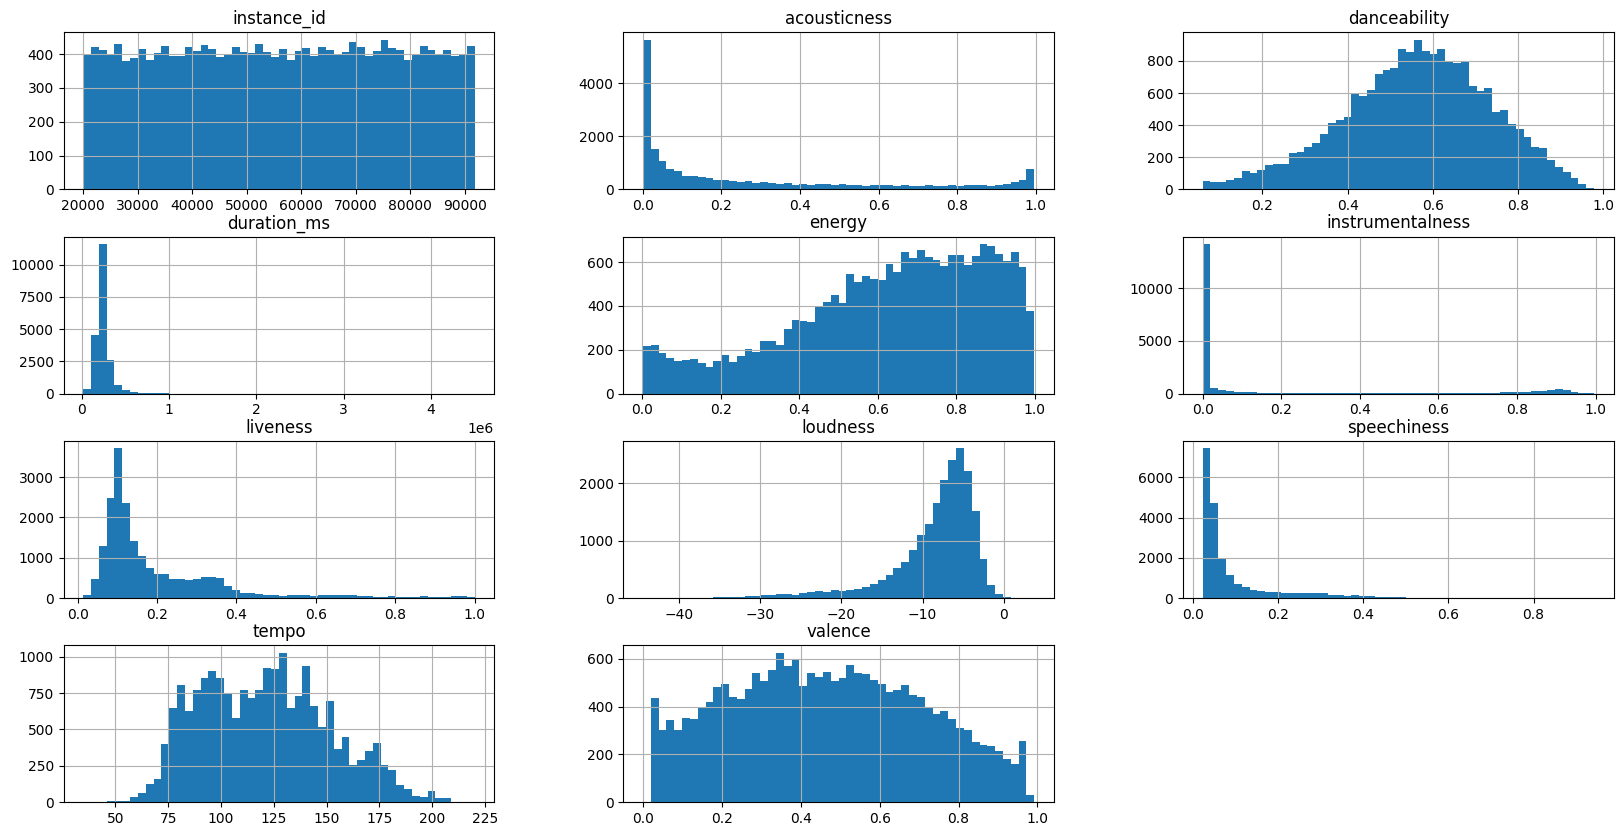

In [ ]:
train.hist(figsize=(20, 10), bins=50)

**Вывод**


*   Тренировочные данные содержат 20394 объектов
*   Каждый объект характеризуется 15 признаками

*   Столбцы key, mode, tempo сожержат пропуски
*   Дублицаты в данных не содержатся






### Аномалии и выбросы

Исходя из таблицы с базовыми статисками, столбец duration_ms, обозначающий продолжительность трека в милисекундах, имеет нулевые и отрицательные значения, что является отклонением

In [ ]:
len(train[train['duration_ms'] <= 0])

2009

Количество значений с аномальной продолжительностью трека = 2009. Заменим их на медиану треков с положительной длиной

In [ ]:
# Рассчитываем медиану положительных значений
median_duration = train[train['duration_ms'] > 0]['duration_ms'].median()
print(f"Медиана положительных значений duration_ms: {median_duration}")

# Заменяем отрицательные значения медианой
train.loc[train['duration_ms'] < 0, 'duration_ms'] = median_duration

Медиана положительных значений duration_ms: 227000.0


Согласно построенным гистограммам выше, можно сделать вывод о том, что переменная instrumentalness имеет выбросы от 0.7 до 1. Посчитаем количество выбросов и выведем статистики.

In [ ]:
len(train[(train['instrumentalness'] >= 0.7) & (train['instrumentalness'] <= 1)])

2714

In [ ]:
instrum_emission = train[(train['instrumentalness'] >= 0.7) & (train['instrumentalness'] <= 1)]

instrum_emission.head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
26,87453.0,"Serenade in B flat, K.361 ""Gran partita"": 3. A...",0.99100,0.154,227000.0,0.0384,0.902,NaN,0.1090,-26.909,Major,0.0405,68.199,4-Apr,0.0393,Classical
27,72660.0,Samba Tranquille,0.31800,0.628,186493.0,0.5690,0.921,A,0.0877,-9.808,Minor,0.0762,197.955,4-Apr,0.4850,Electronic
71,34935.0,Intro To Finale And Closing Music,0.00287,0.315,102853.0,0.6750,0.856,E,0.3330,-7.922,Minor,0.0386,119.823,3-Apr,0.0687,Anime
82,22557.0,Door to Door Cannibals,0.00005,0.496,275600.0,0.8250,0.759,G,0.0379,-4.445,Major,0.0631,147.158,4-Apr,0.5820,Alternative
90,80943.0,ハイキュー!!,0.02000,0.567,234360.0,0.5850,0.870,C,0.0679,-10.229,Major,0.0273,134.972,4-Apr,0.3710,Anime


In [ ]:
instrum_emission.describe()

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,2714.000000,2714.000000,2714.000000,2.714000e+03,2714.000000,2714.000000,2714.000000,2714.000000,2714.000000,2662.000000,2714.000000
mean,56585.138541,0.527944,0.462198,2.768060e+05,0.426556,0.864683,0.165512,-14.837183,0.055021,113.317502,0.318915
std,20587.705241,0.417060,0.203700,1.594573e+05,0.311514,0.066895,0.147395,8.016897,0.043244,31.269941,0.250643
min,20045.000000,0.000000,0.060000,2.904000e+04,0.001010,0.700000,0.019400,-44.406000,0.024300,34.856000,0.023400
25%,39028.250000,0.039625,0.304000,1.889395e+05,0.125250,0.822000,0.092250,-20.370250,0.036300,88.078250,0.103000
50%,56873.500000,0.599000,0.455500,2.363000e+05,0.406000,0.879000,0.112000,-12.920500,0.042800,111.997000,0.251000
75%,74147.500000,0.969000,0.627000,3.316732e+05,0.697000,0.915000,0.163000,-8.511750,0.054800,133.801750,0.492000
max,91742.000000,0.996000,0.964000,2.019293e+06,0.998000,0.996000,0.979000,1.585000,0.596000,213.038000,0.986000


Также переменная liveness имеет выбросы от 0.8 до 1.

In [ ]:
len(train[(train['liveness'] >= 0.8) & (train['instrumentalness'] <= 1)])

335

In [ ]:
liveness_emission = train[(train['liveness'] >= 0.8) & (train['instrumentalness'] <= 1)]

liveness_emission.head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
32,72337.0,Wade in the Water - Live,0.7730,0.559,504760.0,0.267,0.004590,D,0.959,-16.616,Major,0.1550,117.832,4-Apr,0.282,Blues
45,76519.0,Loving Cup,0.1760,0.188,367773.0,0.939,0.000061,G,0.902,-4.398,Major,0.0747,163.556,4-Apr,0.521,Blues
61,44691.0,This Train is Bound for Glory,0.1580,0.392,227000.0,0.942,0.000045,A,0.802,-8.620,Major,0.5590,174.311,4-Apr,0.582,Alternative
173,83493.0,Lost in Music,0.0178,0.468,230000.0,0.884,0.034300,G,0.865,-6.217,Major,0.0729,124.981,4-Apr,0.527,Electronic
217,65963.0,Gimmie That Girl,0.2370,0.560,185333.0,0.877,0.000357,D,0.865,-4.115,Major,0.0966,81.019,4-Apr,0.663,Rock


In [ ]:
liveness_emission.describe()

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,335.000000,335.000000,335.000000,3.350000e+02,335.000000,335.000000,335.000000,335.000000,335.000000,325.000000,335.000000
mean,56533.764179,0.273924,0.482107,2.995623e+05,0.714830,0.137820,0.909848,-8.339057,0.109181,120.680342,0.466465
std,20260.691654,0.306778,0.145833,1.682580e+05,0.228064,0.256936,0.054257,4.288233,0.127462,29.827652,0.210692
min,20103.000000,0.000007,0.066700,2.717900e+04,0.102000,0.000000,0.800000,-25.874000,0.024400,63.423000,0.030600
25%,39761.000000,0.020450,0.374000,2.188735e+05,0.559500,0.000003,0.865000,-10.377500,0.040050,96.481000,0.303500
50%,55532.000000,0.137000,0.484000,2.603470e+05,0.784000,0.000573,0.916000,-7.433000,0.061800,118.945000,0.469000
75%,75135.500000,0.483500,0.582500,3.419535e+05,0.888000,0.113500,0.959000,-5.545500,0.113500,140.093000,0.633500
max,91637.000000,0.988000,0.920000,2.019293e+06,0.999000,0.961000,1.000000,0.000000,0.932000,206.017000,0.977000


### Корреляционный анализ

Построим корреляционную матрицу для выявления зависемостей между признаками.

In [ ]:
!pip install phik

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 8.8 MB/s eta 0:00:00


In [ ]:
import phik

phik_corr = train.phik_matrix()

interval columns not set, guessing: ['instance_id', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable track_name is large: 18643. Are you sure this is not an interval variable? Analysis for pairs of variables including track_name can be slow.
  warnings.warn(


Построим наглядную матрицу корреляции (пока, включающую параметр music genre)

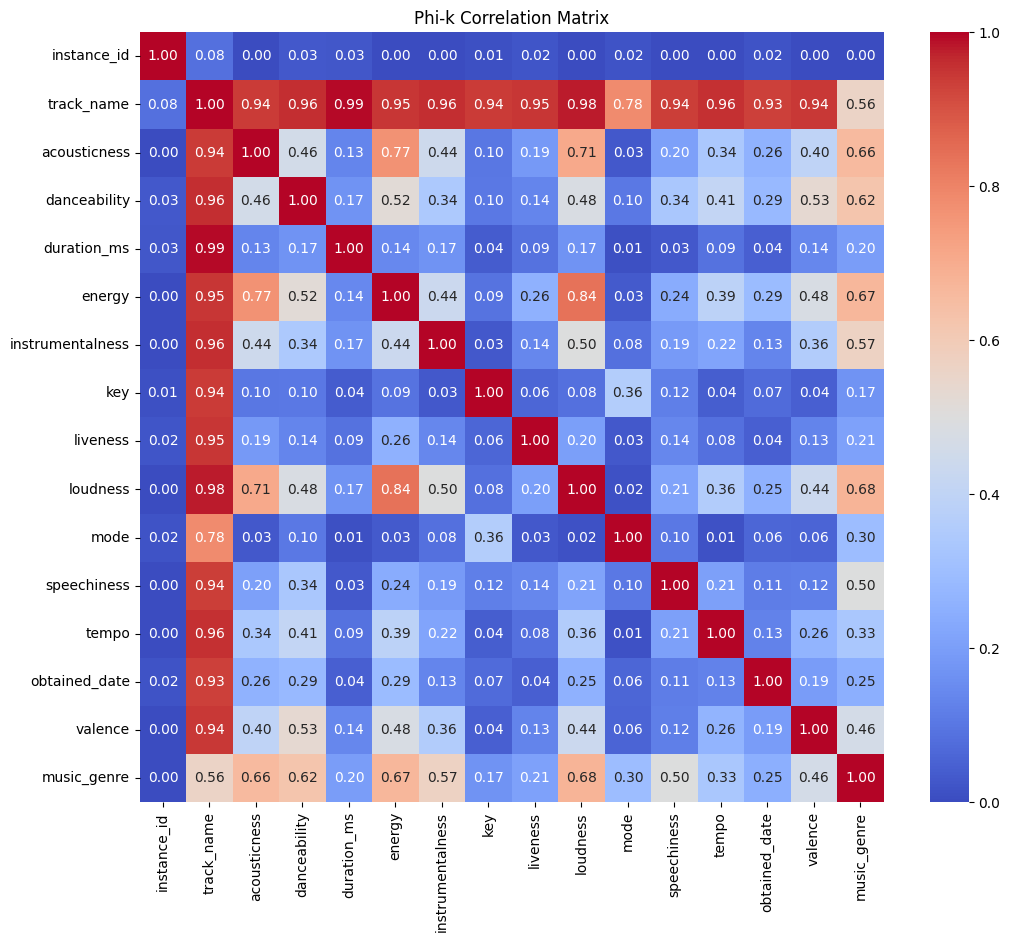

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(phik_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Phi-k Correlation Matrix")
plt.show()

Теперь посмотрим на корреляционную матрицу без параметра music genre

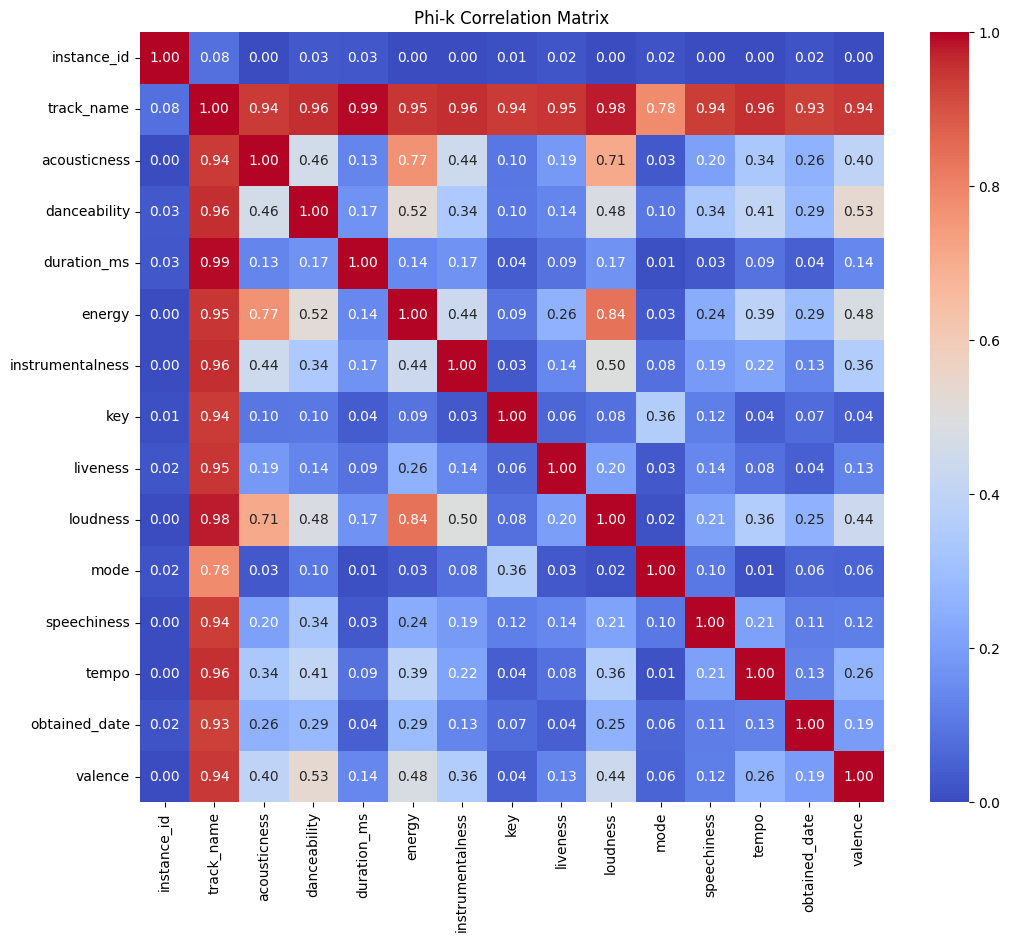

In [ ]:
phik_corr_2 = phik_corr.drop(columns=['music_genre']).drop(index=['music_genre'])

plt.figure(figsize=(12, 10))
sns.heatmap(phik_corr_2, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Phi-k Correlation Matrix")
plt.show()

**Высокая корреляция наблюдается у следующих признаков между собой (> 0.5):**

*   признака acousticness с признаками energy и loudness
*   признака energy и loudness
*   признака valence и danceability



### Предобработка данных: Обработка пропусков

Поработаем с параметрами, где есть пропуски (mode, key, tempo)

In [ ]:
def columns_with_missing_data(train):
    '''
    Функция отображения столбцов, в которых есть пропуски
    '''
    for column in train.columns[train.isnull().any()]:
        print(f"{column:<20}\t{train[column].isnull().mean():.2%}")

In [ ]:
columns_with_missing_data(train)

key                 	3.60%
mode                	2.48%
tempo               	2.17%


Так как процент пропусков в переменных key и mode незначительный, заполним эти пропуски любым имеющимся значением.

In [ ]:
train.value_counts('key')

key
G     2304
C     2149
C#    2125
D     2110
A     2013
F     1616
B     1522
E     1516
G#    1268
A#    1224
F#    1206
D#     606
Name: count, dtype: int64

In [ ]:
train.value_counts('mode')

mode
Major    12828
Minor     7060
Name: count, dtype: int64

Заменим пропуски наиболее частыми значениями

In [ ]:
train.loc[train['key'].isna(), 'key'] = 'G'

train.loc[train['mode'].isna(), 'mode'] = 'Major'

Пропуски в переменной tempo заполним медианой.

In [ ]:
train.loc[train['tempo'].isna(), 'tempo'] = train['tempo'].median()

In [ ]:
# Проверим, что пропусков не осталось
train.isnull().sum()

instance_id         0
track_name          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
obtained_date       0
valence             0
music_genre         0
dtype: int64

##Отбор финального набора обучающих признаков

Задача: предсказание жанра в зависимости от признаков музыкального произведения. Целевая переменная - music_genre.

Отберем признаки, которые войдут в модель.

В соответствии с корреляционной матрицей была выявлена высокая зависимость признаков acousticness, energy, loudness между собой. Таким образом, для уменьшения мультиколлинеарности в модель следует включить только один из этих признаков.

Выберем тот признак, который сильнее всего зависит от целевой переменной, то есть имеет самую высоку корреляцию с целевой переменной music_genre. Самая высокая из трех корреляций - корреляция между целевой переменной и признаком loudness. Из этого следует, что acousticness, energy не войдут в модель.

Далее, признак instance_id, который обозначает уникальный номер музыкального произведения, никак не влияет на жанр музыкального произведения. Таким образом, целесообразно его не включать в модель.

Параметр track_name также исключаем, так как он является текстовым полем, которое само по себе не несет полезной информации для задачи классификации жанров музыки. Высокая корреляция с другими параметрами в данном случае не означает полезность для модели, а скорее указывает на то, что этот параметр может содержать избыточную информацию или вводить шум в модель

Из вышеописанного анализа можно сделать вывод, что в модель классификации музыкального жанра войдут следующие признаки:
* danceability
* duration_ms
* instrumentalness
* key
* liveness
* loudness
* mode
* speechiness
* tempo
* valence

In [ ]:
train.drop(['instance_id', 'track_name', 'acousticness', 'energy', 'obtained_date'], axis= 1 , inplace= True)

In [ ]:
train.head()

,danceability,duration_ms,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,0.670,182653.0,0.017600,D,0.115,-16.842,Major,0.0463,101.384,0.450,Country
1,0.452,187133.0,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,0.539,Rock
2,0.454,173448.0,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,0.344,Alternative
3,0.847,255987.0,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,0.966,Hip-Hop
4,0.742,195333.0,0.000002,C,0.176,-5.550,Major,0.0487,76.494,0.583,Alternative


## Выбор и обучение моделей

Начнем последовательно пробовать разные модели

In [ ]:
# Разделение данных на признаки и целевой столбец
X = train.drop(columns=['music_genre'])
y = train['music_genre']

# Преобразование категориальных признаков с помощью pd.get_dummies
X = pd.get_dummies(X, columns=['key', 'mode'], drop_first=True)


# Разделение данных на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [ ]:
# Создадим и обучим модель RandomForestClassifier
RFC = RandomForestClassifier(min_samples_split=2, max_features=6, max_depth=21, random_state=42)
RFC.fit(X_train, y_train)

# Получим предсказания на обучающей и валидационной выборках
y_train_pred = RFC.predict(X_train)
y_val_pred = RFC.predict(X_val)

# Подсчитаем метрики
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
classification_rep = classification_report(y_val, y_val_pred)
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Выведем результаты
print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("\nClassification Report:\n", classification_rep)
print("\nConfusion Matrix:\n", conf_matrix)

Train Accuracy: 0.9807126511932004
Validation Accuracy: 0.4436163953716415

Classification Report:
               precision    recall  f1-score   support

 Alternative       0.29      0.26      0.27       651
       Anime       0.52      0.44      0.47       475
       Blues       0.40      0.57      0.47       715
   Classical       0.77      0.79      0.78       343
     Country       0.42      0.51      0.46       530
  Electronic       0.58      0.65      0.61       641
     Hip-Hop       0.18      0.06      0.09       286
        Jazz       0.41      0.19      0.26       310
         Rap       0.46      0.66      0.54       607
        Rock       0.17      0.09      0.12       541

    accuracy                           0.44      5099
   macro avg       0.42      0.42      0.41      5099
weighted avg       0.42      0.44      0.42      5099


Confusion Matrix:
 [[169  39 112   0  77  62  11   7 101  73]
 [ 67 208  34  38  51  33   1   7  13  23]
 [ 56  30 404   8  71  41   1  22  

## Оценка качества

Первая использованная модель переобучена, об этом свидетельствует высокий показатель train accuracy (0.98) в сочетании с низким Validation Accuracy (0.44).

Для улучшения модели используем подбор гиперпараметров

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Определение параметров для поиска
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Инициализация модели
RFC = RandomForestClassifier(random_state=42)

# Инициализация GridSearchCV
grid_search = GridSearchCV(estimator=RFC, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Поиск лучших параметров
grid_search.fit(X_train, y_train)

# Вывод лучших параметров
print("Лучшие параметры: ", grid_search.best_params_)

# Использование лучших параметров для обучения модели
best_RFC = grid_search.best_estimator_

# Получение предсказаний и оценка модели
y_train_pred = best_RFC.predict(X_train)
y_val_pred = best_RFC.predict(X_val)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
classification_rep = classification_report(y_val, y_val_pred)
conf_matrix = confusion_matrix(y_val, y_val_pred)

print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("\nClassification Report:\n", classification_rep)
print("\nConfusion Matrix:\n", conf_matrix)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Лучшие параметры:  {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Train Accuracy: 0.8167374959136973
Validation Accuracy: 0.45695234359678366

Classification Report:
               precision    recall  f1-score   support

 Alternative       0.31      0.27      0.29       651
       Anime       0.53      0.45      0.49       475
       Blues       0.40      0.60      0.48       715
   Classical       0.75      0.82      0.78       343
     Country       0.41      0.54      0.46       530
  Electronic       0.56      0.65      0.60       641
     Hip-Hop       0.03      0.00      0.01       286
        Jazz       0.48      0.15      0.23       310
         Rap       0.47      0.74      0.58       607
        Rock       0.20      0.06      0.09       541

    accuracy                           0.46      5099
   macro avg       0.41      0.43      0.40      5099
weighted avg       0.42      0.46      0.42      5099


Confusi

Стало лучше, но попробуем другие варианты, например, градиентный бустинг

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier

# Балансировка данных с использованием SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Инициализация модели GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=42)

# Определение параметров для поиска
param_grid = {
    'n_estimators': [30, 50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [5],
    'subsample': [0.8, 1.0]
}

# Инициализация GridSearchCV
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Поиск лучших параметров
grid_search.fit(X_train_balanced, y_train_balanced)

# Вывод лучших параметров
print("Лучшие параметры: ", grid_search.best_params_)

# Использование лучших параметров для обучения модели
best_gbc = grid_search.best_estimator_

# Получение предсказаний и оценка модели
y_train_pred = best_gbc.predict(X_train_balanced)
y_val_pred = best_gbc.predict(X_val)

train_accuracy = accuracy_score(y_train_balanced, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
classification_rep = classification_report(y_val, y_val_pred)
conf_matrix = confusion_matrix(y_val, y_val_pred)

print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("\nClassification Report:\n", classification_rep)
print("\nConfusion Matrix:\n", conf_matrix)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Лучшие параметры:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Train Accuracy: 0.729304713019132
Validation Accuracy: 0.41106099235144145

Classification Report:
               precision    recall  f1-score   support

 Alternative       0.30      0.22      0.25       651
       Anime       0.47      0.51      0.49       475
       Blues       0.42      0.38      0.40       715
   Classical       0.74      0.77      0.75       343
     Country       0.39      0.55      0.45       530
  Electronic       0.64      0.56      0.60       641
     Hip-Hop       0.22      0.33      0.26       286
        Jazz       0.27      0.35      0.31       310
         Rap       0.45      0.43      0.44       607
        Rock       0.17      0.13      0.15       541

    accuracy                           0.41      5099
   macro avg       0.41      0.42      0.41      5099
weighted avg       0.41      0.41     

Попробуем CatBoost

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Балансировка данных с использованием SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Инициализация модели CatBoostClassifier
catboost_model = CatBoostClassifier(random_state=42, silent=True)

# Определение параметров для поиска
param_grid = {
    'iterations': [100, 200],
    'depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

# Инициализация GridSearchCV
grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Поиск лучших параметров
grid_search.fit(X_train_balanced, y_train_balanced)

# Вывод лучших параметров
print("Лучшие параметры: ", grid_search.best_params_)

# Использование лучших параметров для обучения модели
best_catboost_model = grid_search.best_estimator_

# Получение предсказаний и оценка модели
y_train_pred = best_catboost_model.predict(X_train_balanced)
y_val_pred = best_catboost_model.predict(X_val)

train_accuracy = accuracy_score(y_train_balanced, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
classification_rep = classification_report(y_val, y_val_pred)
conf_matrix = confusion_matrix(y_val, y_val_pred)

print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("\nClassification Report:\n", classification_rep)
print("\nConfusion Matrix:\n", conf_matrix)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Лучшие параметры:  {'depth': 7, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.2}
Train Accuracy: 0.7915590863952333
Validation Accuracy: 0.4482686691697956

Classification Report:
               precision    recall  f1-score   support

 Alternative       0.32      0.27      0.30       613
       Anime       0.47      0.51      0.49       447
       Blues       0.45      0.44      0.45       672
   Classical       0.75      0.80      0.78       325
     Country       0.43      0.54      0.48       498
  Electronic       0.61      0.62      0.61       603
     Hip-Hop       0.23      0.24      0.23       271
        Jazz       0.34      0.37      0.35       293
         Rap       0.48      0.52      0.50       565
        Rock       0.25      0.17      0.20       507

    accuracy                           0.45      4794
   macro avg       0.43      0.45      0.44      4794
weighted avg       0.44      0.45      0.44

Попробуем еще XGBOOST

In [ ]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Преобразование меток классов в числовой формат
le = LabelEncoder()
y = le.fit_transform(y)

# Разделение данных на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Балансировка данных с использованием SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Инициализация модели XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)

# Определение параметров для поиска
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Инициализация GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Поиск лучших параметров
grid_search.fit(X_train_balanced, y_train_balanced)

# Вывод лучших параметров
print("Лучшие параметры: ", grid_search.best_params_)

# Использование лучших параметров для обучения модели
best_xgb_model = grid_search.best_estimator_

# Получение предсказаний и оценка модели
y_train_pred = best_xgb_model.predict(X_train_balanced)
y_val_pred = best_xgb_model.predict(X_val)

train_accuracy = accuracy_score(y_train_balanced, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
classification_rep = classification_report(y_val, y_val_pred, target_names=le.classes_)
conf_matrix = confusion_matrix(y_val, y_val_pred)

print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("\nClassification Report:\n", classification_rep)
print("\nConfusion Matrix:\n", conf_matrix)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Лучшие параметры:  {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Train Accuracy: 0.9837140019860973
Validation Accuracy: 0.43471005423445974

Classification Report:
               precision    recall  f1-score   support

 Alternative       0.29      0.26      0.27       613
       Anime       0.49      0.50      0.50       447
       Blues       0.45      0.43      0.44       672
   Classical       0.77      0.78      0.77       325
     Country       0.43      0.50      0.46       498
  Electronic       0.62      0.63      0.63       603
     Hip-Hop       0.22      0.21      0.21       271
        Jazz       0.35      0.35      0.35       293
         Rap       0.45      0.50      0.47       565
        Rock       0.20      0.18      0.19       507

    accuracy                           0.43      4794
   macro avg       0.43      0.43      0.43      4794
weighted av

## Улучшение качества модели с помощью отбора обучающих признаков (feature selection)

Для улучшения качества модели следует отобрать самые важные признаки, влияющие на целевую переменную.

Для определения важности признака используем Random Forest.

In [ ]:
feature_name = X.columns.tolist()

In [ ]:
clf = RandomForestClassifier()
clf.fit(X, y)

RandomForestClassifier()

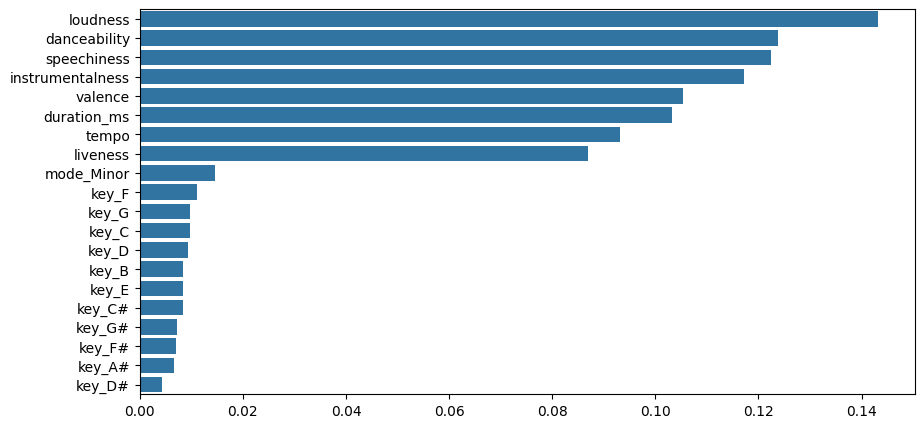

In [ ]:
plot = sns.barplot(y=feature_name,
                   x=clf.feature_importances_,
                   order=np.array(feature_name)[np.argsort(clf.feature_importances_)][::-1]
                   )
plot.figure.set_size_inches(10, 5)

С помощью построенного барплота можно сделать вывод о следующих важных признаках:
- loudness
- danceability
- speechness
- instrumentalness
- valence
- duration_ms
- tempo
- liveness

Попробуем удалить остальные признаки из нашего датасета и обучить модель только на важных признаках.

In [ ]:
train.drop(['mode', 'key'], axis= 1 , inplace= True)

In [ ]:
# Разделение данных на признаки и целевой столбец
X = train.drop(columns=['music_genre'])
y = train['music_genre']


# Разделение данных на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [ ]:
# Создадим и обучим модель RandomForestClassifier
RFC = RandomForestClassifier(min_samples_split=2, max_features=6, max_depth=21, random_state=42)
RFC.fit(X_train, y_train)

# Получим предсказания на обучающей и валидационной выборках
y_train_pred = RFC.predict(X_train)
y_val_pred = RFC.predict(X_val)

# Подсчитаем метрики
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
classification_rep = classification_report(y_val, y_val_pred)
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Выведем результаты
print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("\nClassification Report:\n", classification_rep)
print("\nConfusion Matrix:\n", conf_matrix)

Train Accuracy: 0.9803203661327231
Validation Accuracy: 0.4345950186311041

Classification Report:
               precision    recall  f1-score   support

 Alternative       0.27      0.25      0.26       651
       Anime       0.51      0.47      0.49       475
       Blues       0.41      0.54      0.46       715
   Classical       0.77      0.79      0.78       343
     Country       0.40      0.50      0.44       530
  Electronic       0.58      0.61      0.59       641
     Hip-Hop       0.21      0.09      0.13       286
        Jazz       0.39      0.19      0.25       310
         Rap       0.47      0.64      0.54       607
        Rock       0.15      0.09      0.11       541

    accuracy                           0.43      5099
   macro avg       0.41      0.42      0.41      5099
weighted avg       0.41      0.43      0.42      5099


Confusion Matrix:
 [[161  51 104   1  77  58  17   6  95  81]
 [ 56 222  34  36  53  31   0   5  13  25]
 [ 66  30 388  10  68  40   2  24  

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Определение параметров для поиска
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Инициализация модели
RFC = RandomForestClassifier(random_state=42)

# Инициализация GridSearchCV
grid_search = GridSearchCV(estimator=RFC, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Поиск лучших параметров
grid_search.fit(X_train, y_train)

# Вывод лучших параметров
print("Лучшие параметры: ", grid_search.best_params_)

# Использование лучших параметров для обучения модели
best_RFC = grid_search.best_estimator_

# Получение предсказаний и оценка модели
y_train_pred = best_RFC.predict(X_train)
y_val_pred = best_RFC.predict(X_val)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
classification_rep = classification_report(y_val, y_val_pred)
conf_matrix = confusion_matrix(y_val, y_val_pred)

print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("\nClassification Report:\n", classification_rep)
print("\nConfusion Matrix:\n", conf_matrix)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Лучшие параметры:  {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Train Accuracy: 0.5550179797319386
Validation Accuracy: 0.45871739556775837

Classification Report:
               precision    recall  f1-score   support

 Alternative       0.30      0.25      0.28       651
       Anime       0.54      0.44      0.48       475
       Blues       0.38      0.61      0.47       715
   Classical       0.77      0.82      0.80       343
     Country       0.38      0.57      0.46       530
  Electronic       0.56      0.65      0.60       641
     Hip-Hop       0.00      0.00      0.00       286
        Jazz       0.51      0.15      0.23       310
         Rap       0.48      0.78      0.60       607
        Rock       0.22      0.02      0.04       541

    accuracy                           0.46      5099
   macro avg       0.41      0.43      0.39      5099
weighted avg       0.42      0.46      0.41      5099


Confusion

**ИТОГО:** наш лучший результат **0.46**

# Обработка данных из файла test

In [ ]:
test.head(5)

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
0,48564,Low Class Conspiracy,0.301000,0.757,146213.0,0.679,0.00000,A#,0.3030,-7.136,Minor,0.3560,90.361,4-Apr,0.895
1,72394,The Hunter,0.538000,0.256,240360.0,0.523,0.00832,G#,0.0849,-5.175,Major,0.0294,78.385,4-Apr,0.318
2,88081,Hate Me Now,0.005830,0.678,284000.0,0.770,0.00000,A,0.1090,-4.399,Minor,0.2220,90.000,4-Apr,0.412
3,78331,Somebody Ain't You,0.020300,0.592,177354.0,0.749,0.00000,B,0.1220,-4.604,Major,0.0483,160.046,4-Apr,0.614
4,72636,Sour Mango,0.000335,0.421,-1.0,0.447,0.01480,D,0.0374,-8.833,Major,0.2020,73.830,4-Apr,0.121


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB


In [ ]:
test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
instance_id,5099.0,55643.871347,20762.384803,20012.000000,37571.00000,55246.000000,73702.00000,91709.000
acousticness,5099.0,0.276324,0.322657,0.000002,0.01660,0.120000,0.46000,0.996
danceability,5099.0,0.561888,0.170502,0.059600,0.45100,0.568000,0.68100,0.977
duration_ms,5099.0,217397.407727,115637.408282,-1.000000,173733.50000,217500.000000,264247.00000,1360027.000
energy,5099.0,0.622030,0.251829,0.001540,0.46500,0.660000,0.82600,0.999
instrumentalness,5099.0,0.165198,0.311940,0.000000,0.00000,0.000157,0.09275,0.994
liveness,5099.0,0.197924,0.166241,0.020400,0.09695,0.129000,0.24800,0.990
loudness,5099.0,-8.630186,5.619766,-46.122000,-10.23100,-7.135000,-5.12700,1.949
speechiness,5099.0,0.092718,0.100130,0.022600,0.03570,0.048700,0.09655,0.918
tempo,4978.0,121.246463,29.875950,37.114000,96.07025,120.053500,141.93425,216.029


In [ ]:
test.isnull().sum()

instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 158
liveness              0
loudness              0
mode                149
speechiness           0
tempo               121
obtained_date         0
valence               0
dtype: int64

array([[<Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'duration_ms'}>],
       [<Axes: title={'center': 'energy'}>,
        <Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>],
       [<Axes: title={'center': 'loudness'}>,
        <Axes: title={'center': 'speechiness'}>,
        <Axes: title={'center': 'tempo'}>],
       [<Axes: title={'center': 'valence'}>, <Axes: >, <Axes: >]],
      dtype=object)

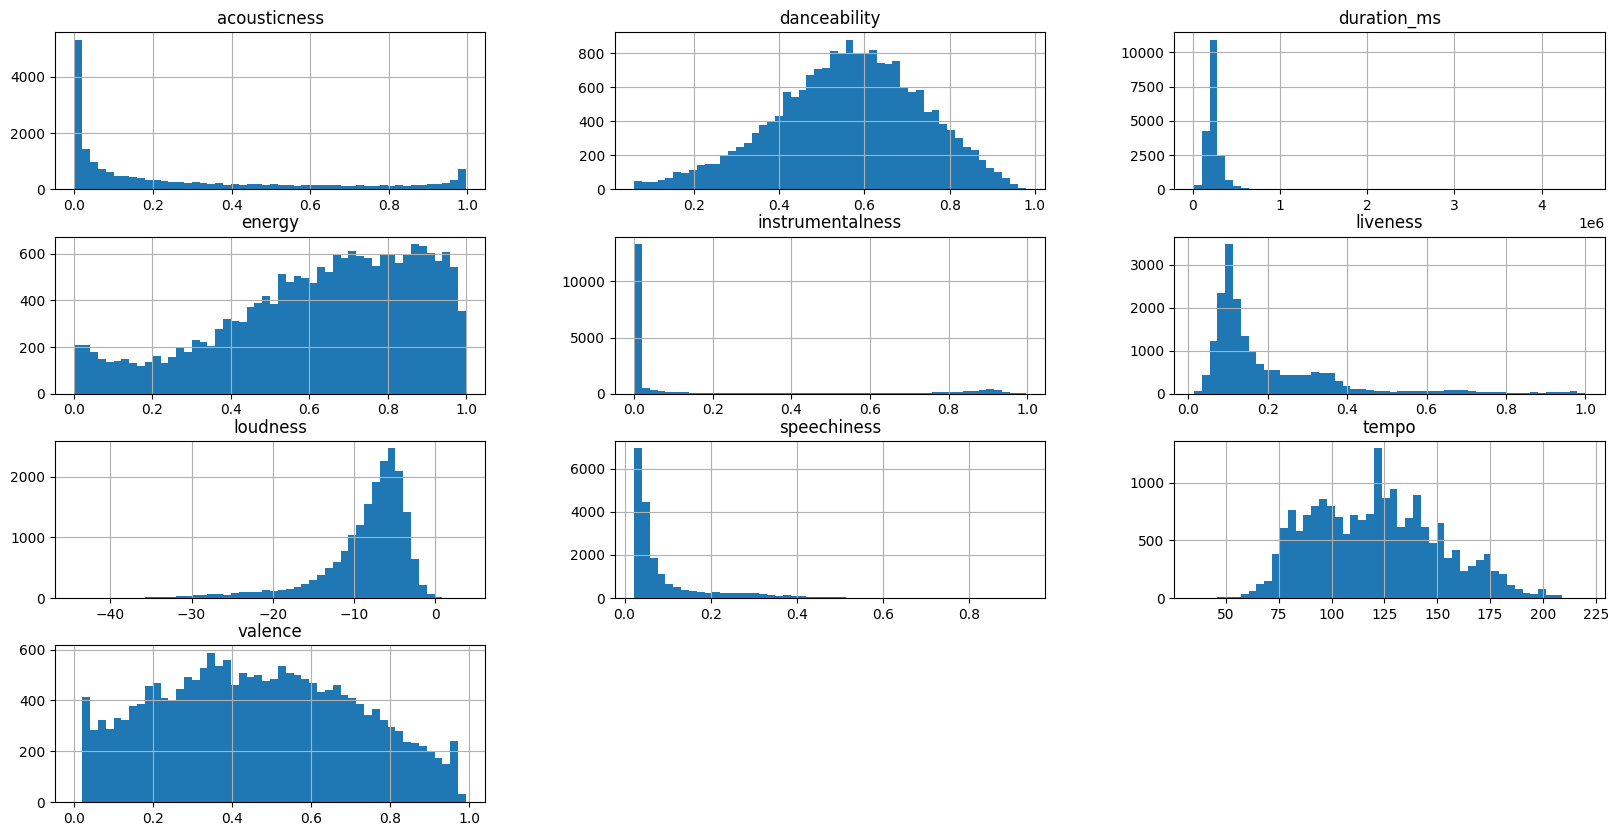

In [ ]:
train.hist(figsize=(20, 10), bins=50)

Данные в файле test очень похожи по характеристикам на данные файла train. Проведем с ними такие же манипуляции:

1. Уберем ненунжные столбцы: instance_id, track_name, obtained_date, energy, acousticness, mode, key (последние 2 признака удаляем, т.к. их убрали на шаге улучшения модели)
2. Заполним медианными значениями пропуски в поле tempo
3. Заполним медианными значениями продолжительности треков те значения, где продолжительность отрицательная

In [ ]:
test=test.drop(['instance_id', 'track_name', 'acousticness', 'energy', 'obtained_date', 'mode', 'key'], axis=1)

In [ ]:
test.loc[:, ("tempo")]=test.loc[:, ("tempo")].fillna(test.loc[:, ("tempo")].median().round(2))  #заполним пропуски медианой

In [ ]:
len(test[test['duration_ms'] <= 0])

509

In [ ]:
# Рассчитываем медиану положительных значений
median_duration = test[test['duration_ms'] > 0]['duration_ms'].median()
print(f"Медиана положительных значений duration_ms: {median_duration}")

# Заменяем отрицательные значения медианой
test.loc[test['duration_ms'] < 0, 'duration_ms'] = median_duration

Медиана положительных значений duration_ms: 226108.5


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      5099 non-null   float64
 1   duration_ms       5099 non-null   float64
 2   instrumentalness  5099 non-null   float64
 3   liveness          5099 non-null   float64
 4   loudness          5099 non-null   float64
 5   speechiness       5099 non-null   float64
 6   tempo             5099 non-null   float64
 7   valence           5099 non-null   float64
dtypes: float64(8)
memory usage: 318.8 KB


## Прогонаяем модель на данных файла Test

In [ ]:
X_test = test

# Приведение к тому же набору столбцов, что и в тренировочных данных
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Получим предсказания на тестовом наборе данных
y_test_pred = best_RFC.predict(X_test)

Так как у нас в тестовом файле нет истинных меток (исходного столбца music_genre, мы можем только предсказать жанры и сохранить результаты в CSV-файл

In [ ]:
predictions = pd.DataFrame({'instance_id': test['instance_id'], 'predicted_genre': y_test_pred})
predictions.to_csv('music_genre_predictions.csv', index=False)

print("Predictions have been saved to 'music_genre_predictions.csv'")

Predictions have been saved to 'music_genre_predictions.csv'
